# Gather Dataset

In [6]:
from icrawler.builtin import GoogleImageCrawler
import datetime
def datetime2tuple(date):
    return (date.year, date.month, date.day)
def gather_data(n_total_images,n_per_crawl,keyword, folder_name):
    delta = datetime.timedelta(days=30)
    end_day = datetime.datetime(2023, 3, 17)
    for i in range(int(n_total_images / n_per_crawl )):
        start_day = end_day - delta
        google_crawler = GoogleImageCrawler(downloader_threads=4, storage={'root_dir': folder_name})
        google_crawler.crawl(keyword=keyword[i], filters={'date':(datetime2tuple(start_day), datetime2tuple(end_day))}, file_idx_offset=i*n_per_crawl , max_num=n_per_crawl)
        end_day = start_day - datetime.timedelta(days=1)

#gather_data(700,100,['packages ready to ship','packages about to be sent','cardboard boxes','packages','box packages','sealed packages','delivery cardboard package box'],'goodpackages')
#gather_data(200,100,['ripped cardboard boxes','ripped packages'],'rippedpackages') #ripped
#gather_data(200,100,['destroyed packages','damaged cardboard boxes'],'crushedpackages') #crushed
#gather_data(200,100,['cardboard boxes with water damage','wet cardboard boxes'],'leakingpackages')#leaking
#gather_data(200,100,['burned cardboard','charred cardboard'],'burnedpackages') # burned
#gather_data(200,100,['cardboard recycling pile','broken down cardboard boxes'],'foldedpackages')#folded

# Split the Data

In [7]:
import splitfolders
import shutil
import os
input_folder = "data\\startingdata\\"
output_folder = "data\\split data\\"
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.8, 0, .2))
subsets = ['test\\', 'train\\']
for subset in subsets:
    output = output_folder+subset
    destination = "data\\split data\\"+subset+"\\badpackages\\"
    categories = ['burnedpackages', 'crushedpackages',
                  'foldedpackages', 'leakingpackages', 'rippedpackages']
    for category in categories:
        source_folder = output + category
        for file_name in os.listdir(source_folder):

            if os.path.exists(destination + '\\' + file_name):
                data = os.path.splitext(file_name)
                only_name = data[0]
                extension = data[1]
                new_base = category + only_name + extension
                new_name = os.path.join(destination, new_base)
                shutil.move(source_folder + '\\' + file_name, new_name)
            else:
                shutil.move(source_folder + '\\' + file_name,
                            destination + '\\' + file_name)
        os.rmdir(source_folder)


Copying files: 1085 files [00:01, 657.81 files/s]


# Processing the Data

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50
from tensorflow.keras.layers import Conv2D,Dense, Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import numpy

img_height,img_width = (224,224)
batch_size = 32

train_data_path = "data/split data/train/"
test_data_path = "data/split data/test/"

In [9]:
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,shear_range=.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.4) #might not need validation split
training_data_generator = training_datagen.flow_from_directory(train_data_path,target_size=(img_height,img_width),batch_size=batch_size,class_mode='categorical',subset='training')
testing_data_generator = training_datagen.flow_from_directory(test_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')


Found 520 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
base_model = ResNet50(include_top=False,weights='imagenet')
output=base_model.output
output=GlobalAveragePooling2D()(output)
output=Dense(1024,activation='relu')(output)
predictions = Dense(training_data_generator.num_classes,activation='softmax')(output)
model = Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(training_data_generator,epochs=10)
model.save('Models\\Resnet50\\Resnet50_with_50_10_datasplit.h5')

Epoch 1/10
17/17 [==============================] - 37s 2s/step - loss: 1.4643 - accuracy: 0.6788
Epoch 2/10
17/17 [==============================] - 41s 2s/step - loss: 0.5168 - accuracy: 0.8231
Epoch 3/10
17/17 [==============================] - 39s 2s/step - loss: 0.2916 - accuracy: 0.8885
Epoch 4/10
17/17 [==============================] - 40s 2s/step - loss: 0.2181 - accuracy: 0.9000
Epoch 5/10
17/17 [==============================] - 32s 2s/step - loss: 0.1573 - accuracy: 0.9404
Epoch 6/10
17/17 [==============================] - 32s 2s/step - loss: 0.1162 - accuracy: 0.9615
Epoch 7/10
17/17 [==============================] - 33s 2s/step - loss: 0.1046 - accuracy: 0.9654
Epoch 8/10
17/17 [==============================] - 33s 2s/step - loss: 0.1864 - accuracy: 0.9250
Epoch 9/10
17/17 [==============================] - 32s 2s/step - loss: 0.0826 - accuracy: 0.9731
Epoch 10/10
17/17 [==============================] - 30s 2s/step - loss: 0.1130 - accuracy: 0.9558


# Evaluation

In [12]:
test_loss,test_accuracy = model.evaluate(testing_data_generator,verbose=2)
print(test_accuracy)

87/87 - 8s - loss: 0.7483 - accuracy: 0.8276 - 8s/epoch - 95ms/step
0.8275862336158752


In [28]:

import tensorflow

model = tensorflow.keras.models.load_model("Models\\Resnet50\\Resnet50_with_50_10_datasplit.h5")
files = testing_data_generator.filenames
samples = len(testing_data_generator)
predicted = []
actual=[]
testing_data_generator.reset()
for i in range(samples):
    x,y=testing_data_generator.next()
    predicted.append((model.predict(x)))
    actual.append(y)


1/1 [==============================] - 1s 958ms/step
[[1. 0.]]
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
1/1 [==============================] - 0s 82ms/step
[[0. 1.]]
1/1 [==============================] - 0s 85ms/step
[[1. 0.]]
1/1 [==============================] - 0s 81ms/step
[[1. 0.]]
1/1 [==============================] - 0s 82ms/step
[[0. 1.]]
1/1 [==============================] - 0s 85ms/step
[[1. 0.]]
1/1 [==============================] - 0s 91ms/step
[[1. 0.]]
1/1 [==============================] - 0s 84ms/step
[[1. 0.]]
1/1 [==============================] - 0s 78ms/step
[[0. 1.]]
1/1 [==============================] - 0s 78ms/step
[[1. 0.]]
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
1/1 [==============================] - 0s 82ms/step
[[1. 0.]]
1/1 [==============================] - 0s 82ms/step
[[1. 0.]]
1/1 [==============================] - 0s 88ms/step
[[0. 1.]]
1/1 [==============================] - 0s 83ms/step
[[1. 0.]]
1/1 [=

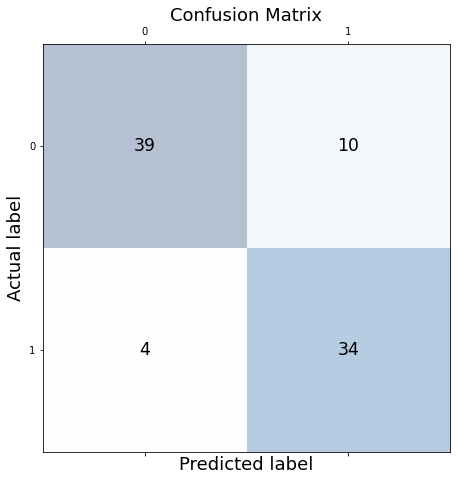

Accuracy: 0.8390804597701149
Precision: 0.7959183673469388
Recall: 0.9069767441860465
Specificity: 0.7727272727272727
F1-Score: 0.8478260869565216


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
predicted_class = [i.argmax() for i in predicted]
actual_class = [i.argmax() for i in actual]
conf_matrix = confusion_matrix(actual_class, predicted_class)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('Actual label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
recall = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])

print("Accuracy:",  (conf_matrix[0][0]+conf_matrix[1][1])/((conf_matrix[0][0]+conf_matrix[0][1])+(conf_matrix[1][0]+conf_matrix[1][1])))
print("Precision:",  precision)
print("Recall:",  recall)
print("Specificity:",  (conf_matrix[1][1])/(conf_matrix[1][1]+conf_matrix[0][1]))
print("F1-Score:",  (2*precision * recall)/(precision+recall))
